**NOTE:** This Jupyter notebook is derived from the Jupyter notebook located at https://github.com/ageron/handson-ml as of 01/06/2019, as discussed in Hands-On Machine Learning. It is used here for educational purposes only.

**Chapter 3 – Classification**

_This notebook contains all the sample code and solutions to the exercises in chapter 3._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [93]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "../.."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    try:
        plt.savefig(path, format='png', dpi=300)
    except:
        plt.savefig(fig_id + ".png", format='png', dpi=300)

# Loans - Exploratory Data Analysis (EDA)

**Warning**: `fetch_mldata()` is deprecated since Scikit-Learn 0.20. You should use `fetch_openml()` instead. However, it returns the unsorted MNIST dataset, whereas `fetch_mldata()` returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [94]:
from pathlib import Path

github_p = "https://raw.githubusercontent.com/Finance-781/FinML/master/Lecture%203%20-%20Classification/Inclass/"

my_file = Path("data/loans.csv") # Defines path
if my_file.is_file():              # See if file exists
    print("Local file found")      
    df = pd.read_csv('data/loans.csv')
else:
    print("Be patient: loading from github (2 minutes)")
    df = pd.read_csv(github_p+'data/loans.csv')
    print("Done")


Be patient: loading from github (2 minutes)
Done


In [95]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Replace the name of some columns
df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

# Drop irrelevant columns
df.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title'], axis=1, inplace=True)


## Similar Distributions:
<a id="similar_distributions"></a>
We will start by exploring the distribution of the loan amounts and see when did the loan amount issued increased significantly. <br>

<h4> What we need to know: </h4> <br>
<ul>
<li> Understand what amount was <b>mostly issued</b> to borrowers. </li>
<li> Which <b>year</b> issued the most loans. </li>
<li> The distribution of loan amounts is a <b>multinomial distribution </b>.</li>
</ul>


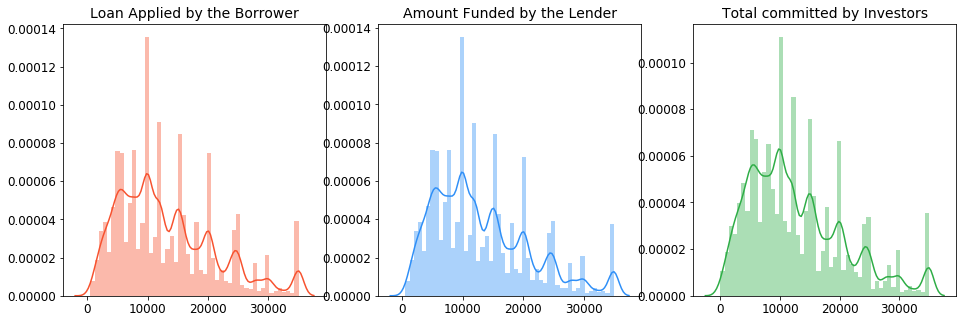

In [5]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values

sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=14)

In [6]:
# Lets' transform the issue dates by year.
df['issue_d'].head()
dt_series = pd.to_datetime(df['issue_d'], errors = 'coerce')
df['year'] = dt_series.dt.year


Loan Status and Issuance Amount: </h2>
<a id="types_of_loans"></a>
In this section, we will see what is the amount of bad loans declared so far, of course we have to understand that there are still loans that are at a risk of defaulting in the future. 


In [7]:
df["loan_status"].value_counts()

Fully Paid                                             54314
Current                                                32417
Charged Off                                            11237
Does not meet the credit policy. Status:Fully Paid      1988
Late (31-120 days)                                       969
Does not meet the credit policy. Status:Charged Off      761
In Grace Period                                          457
Late (16-30 days)                                        153
Default                                                   92
Name: loan_status, dtype: int64

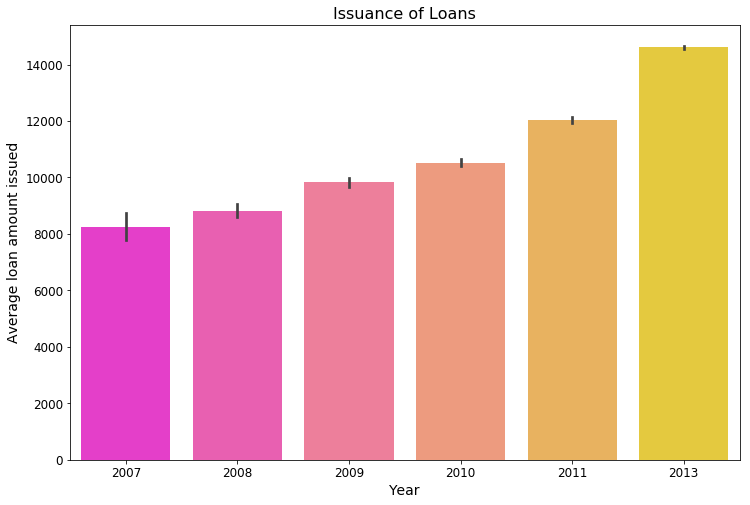

In [8]:
# The year of 2015 was the year were the highest amount of loans were issued 
# This is an indication that the economy is quiet recovering itself.
plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amount', data=df, palette='spring')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)

## The Importance of Credit Scores:
<a id="credit_scores"></a>
Credit scores are important metrics for assesing the overall level of risk. In this section we will analyze the level of risk as a whole and how many loans were bad loans by the type of grade received in the credit score of the customer.

<h4> What we need to know: </h4>
<ul> 
<li> The lower the grade of the credit score, the higher the risk for investors. </li>
<li> There are different factors that influence on the level of risk of the loan.</li>
</ul>

<h4> Summary: </h4>
<ul>
<li> The scores that has a lower grade received a larger amounts of loans (which might had contributed to a higher level of risk). </li>
<li> Logically, the <b>lower the grade the higher the interest</b> the customer had to pay back to investors.</li>
<ul>

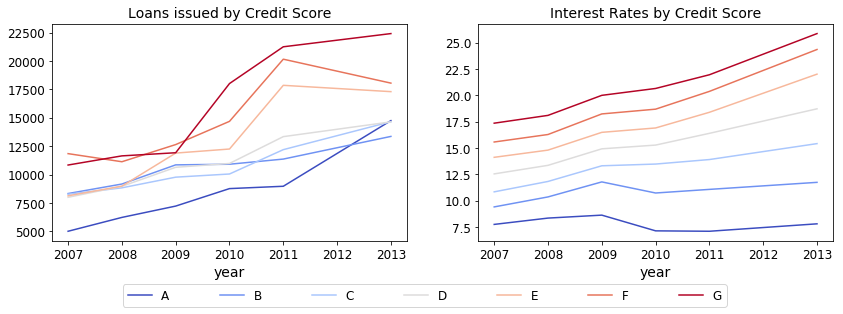

In [9]:
# Let's visualize how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).loan_amount.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)
    
    
by_inc = df.groupby(['year', 'grade']).interest_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

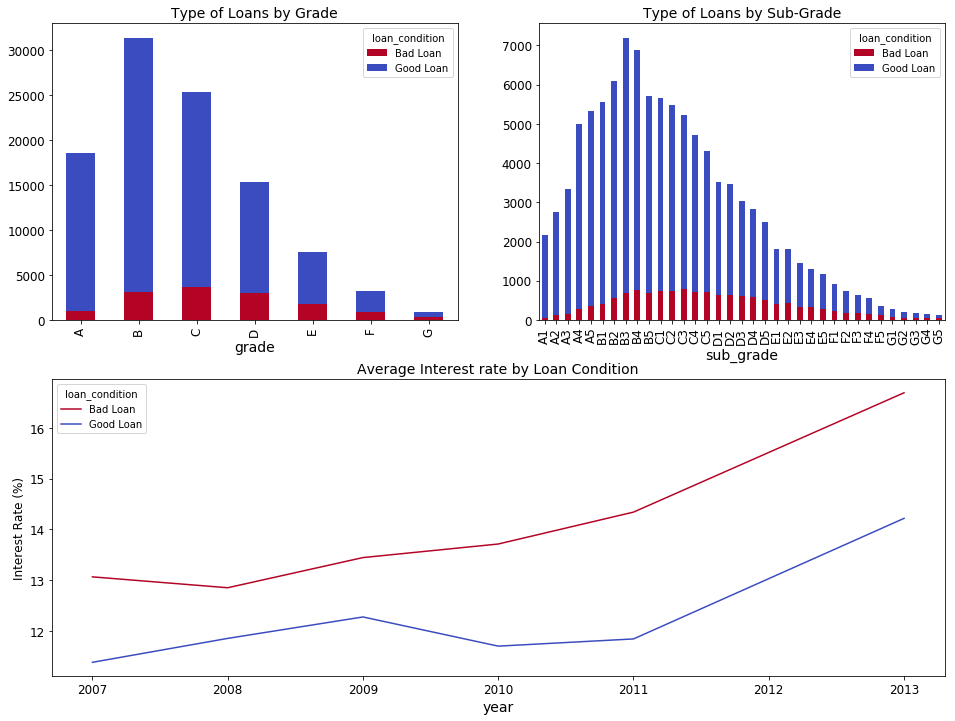

In [10]:
# Determining the loans that are bad from loan_status column
%matplotlib inline  

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)


fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'loan_condition']).interest_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

## Data Cleaning and Feature Engineering

In [11]:
target_list = [1 if i=='Bad Loan' else 0 for i in df['loan_condition']]

df['loan_condition'] = target_list
df['loan_condition'].value_counts()

0    88719
1    13669
Name: loan_condition, dtype: int64

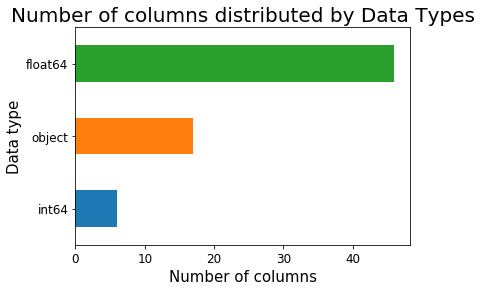

In [12]:
# Number of columns for each data type
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

We would want to label encode the columns that have 2 categories and one-hot encode columns with more than 2 categories. Also, columns like emp_title, url, desc, etc. should be dropped because there aren't any large number of unique data for any of the categories they contain. Principal Component Analysis can also be carried out for the one-hot encoded columns to bring the feature dimensions down.

In [13]:
df.head()

,loan_amount,funded_amount,investor_funds,term,interest_rate,installment,grade,sub_grade,emp_length,home_ownership,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,year,loan_condition
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,0
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,1
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,0
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,0




First, I'll be converting the date object columns into integer number of years or months just because I do not want to blow up the number of feature columns by performing one-hot encoding on them. For filling the null values I have taken the dates with the highest number of counts.


In [14]:
df['issue_d']= pd.to_datetime(df['issue_d']).apply(lambda x: int(x.strftime('%Y')))
df['last_pymnt_d']= pd.to_datetime(df['last_pymnt_d'] .fillna(str(df['last_pymnt_d'].mode().values[0])),format='%d/%m/%y').dt.month
df['last_credit_pull_d']= pd.to_datetime(df['last_credit_pull_d'] .fillna(str(df['last_credit_pull_d'].mode().values[0])),format='%d/%m/%y').dt.month
df['earliest_cr_line']= pd.to_datetime(df['earliest_cr_line'] .fillna(str(df['earliest_cr_line'].mode().values[0])),format='%d/%m/%y').dt.month
df['next_pymnt_d'] = pd.to_datetime(df['next_pymnt_d'] .fillna(str(df['next_pymnt_d'].mode().values[0])),format='%d/%m/%y').dt.year

Some more cleanup

In [15]:
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(df['mths_since_last_delinq'].median())
df['emp_length'].fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)

Let's see how we can handle our categorical data. Two of the methods we can use are Label Encoding and One Hot Encoding. The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. So, If we only have two unique values for a categorical variable (such as Yes/No), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the better option. However, due to the large number of columns originated after One-Hot Encoding, we may have to conduct Principle Component Analysis (PCA) for dimensionality reduction.


In [16]:
from sklearn import preprocessing
count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:     
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count)

term
pymnt_plan
initial_list_status
application_type
4 columns were label encoded.



And one-hot encoding the rest of the categorical columns,


In [17]:
cols_drop = ["loan_status","loan_condition"]
extra_cols = df[cols_drop]
df = pd.get_dummies(df.drop(cols_drop, axis=1))
df = pd.concat((extra_cols, df),axis=1)

For the 'mths_since_last_delinq' column, I'll be filling in the missing value with the median of the columns as the data in the column is continuous.

Let me remove all the columns with more than 70% missing data as they won't be helping for modelling and exploration.

In [18]:
temp = [i for i in df.count()<len(df) *0.30]
df.drop(df.columns[temp],axis=1,inplace=True)

Drop the rows records with null values; in practice you should find a way to fill these values.

In [19]:
df.dropna(inplace=True)

Now we have about 60,000 records lef

# Binary classifier

In [20]:
X = df.drop(["loan_condition","loan_status"],axis=1).values
y = df["loan_condition"].values

In [21]:
len(df)

59815

In [22]:
X_train, X_test, y_train, y_test = X[:40000], X[40000:], y[:40000], y[40000:]

In [23]:
import numpy as np

shuffle_index = np.random.permutation(40000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
y_train_c = y_train.copy()

In [24]:
df.head()

,loan_status,loan_condition,loan_amount,funded_amount,investor_funds,term,interest_rate,installment,annual_income,issue_d,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
42535,Current,0,27050,27050,27050.0,0,10.99,885.46,55000.0,2013,...,0,0,0,0,0,0,0,0,0,0
42536,Current,0,9750,9750,9750.0,0,13.98,333.14,26000.0,2013,...,0,0,0,0,0,0,0,0,0,0
42537,Current,0,12000,12000,12000.0,0,6.62,368.45,105000.0,2013,...,0,0,0,0,0,0,0,0,0,0
42538,Fully Paid,0,12000,12000,12000.0,0,13.53,407.40,40000.0,2013,...,0,0,0,0,0,0,0,0,0,0
42539,Current,0,15000,15000,15000.0,0,8.90,476.30,63000.0,2013,...,0,0,0,0,0,0,0,0,0,0


**Note**: a few hyperparameters will have a different default value in future versions of Scikit-Learn, so a warning is issued if you do not set them explicitly.

In [25]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=-inf, verbose=0, warm_start=False)

In [26]:
sgd_clf.predict([X_test[0]]) # Predicts Good Loan

array([0])

In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.96370181, 0.95739893, 0.95559889])

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9637018149092546
0.9573989349733744
0.9555988899722493


In [29]:
from sklearn.base import BaseEstimator
class NeverClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [30]:
never_clf = NeverClassifier()
cross_val_score(never_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87978101, 0.88314708, 0.88157204])

In [31]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[34766,   494],
       [ 1150,  3590]])

In [33]:
y_train_perfect_predictions = y_train

In [34]:
confusion_matrix(y_train, y_train_perfect_predictions)

array([[35260,     0],
       [    0,  4740]])

In [35]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred)

0.8790401567091087

In [36]:
3590 / (3590 + 494)

0.8790401567091087

In [37]:
recall_score(y_train, y_train_pred)

0.7573839662447257

In [38]:
3590 / (3590 + 1150)

0.7573839662447257

In [39]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.813689936536718

In [40]:
3590 / (3590 + (1150 + 494)/2)

0.8136899365367181

In [41]:
y_scores = sgd_clf.decision_function([X_test[0]])
y_scores

array([-2.36837771e+09])

In [42]:
top = y_scores[0]*1.1

In [43]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [44]:
y_some_digit_pred

array([False])

In [45]:
threshold =  top
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [46]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3,
                             method="decision_function")

In [47]:
y_scores

array([-6.80003005e+09, -1.86529563e+09, -4.64893547e+09, ...,
        7.64874955e+09, -5.31379025e+09, -2.46661750e+09])

Note: there was an [issue](https://github.com/scikit-learn/scikit-learn/issues/9589) in Scikit-Learn 0.19.0 (fixed in 0.19.1) where the result of `cross_val_predict()` was incorrect in the binary classification case when using `method="decision_function"`, as in the code above. The resulting array had an extra first dimension full of 0s. Just in case you are using 0.19.0, we need to add this small hack to work around this issue:

In [48]:
y_scores.shape

(40000,)

In [49]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [50]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

Saving figure precision_recall_vs_threshold_plot


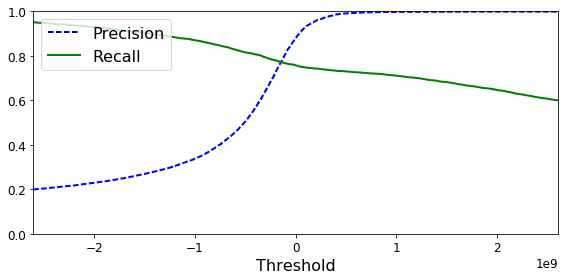

In [51]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([top, -top])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [52]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


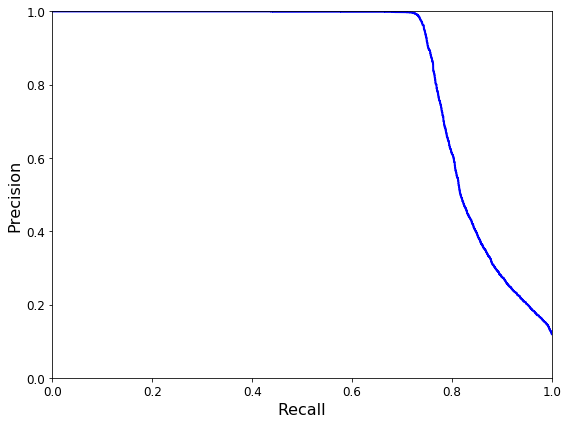

In [53]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

# ROC curves

In [54]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

Saving figure roc_curve_plot


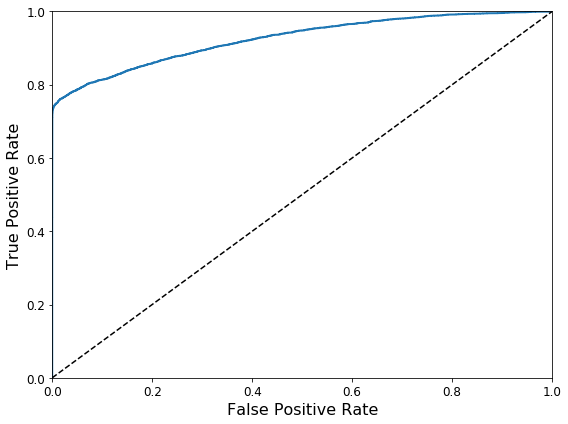

In [55]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_scores)

0.9251680823107907

**Note**: we set `n_estimators=10` to avoid a warning about the fact that its default value will be set to 100 in Scikit-Learn 0.22.

In [57]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,
                                    method="predict_proba")

In [58]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)

Saving figure roc_curve_comparison_plot


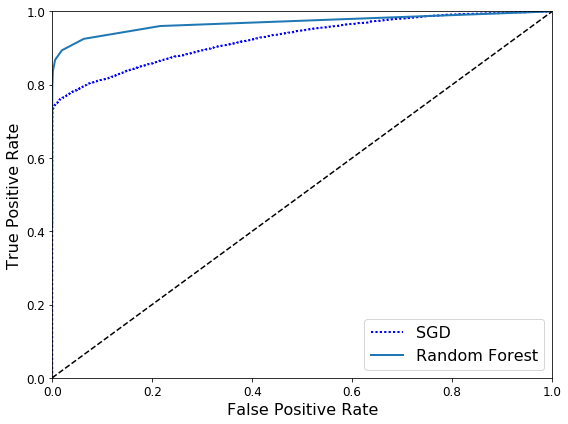

In [59]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [60]:
roc_auc_score(y_train, y_scores_forest)

0.9690842469802384

In [61]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3)
precision_score(y_train, y_train_pred_forest)

0.9978802331743508

In [62]:
recall_score(y_train, y_train_pred_forest)

0.7945147679324894

# Multiclass classification

In [63]:
df["loan_status"].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'Late (16-30 days)',
       'Charged Off', 'In Grace Period', 'Default'], dtype=object)

In [64]:
df["loan_status"] = le.fit_transform(df["loan_status"])

In [65]:
df["loan_status"].unique()

array([1, 3, 6, 5, 0, 4, 2])

In [66]:
import numpy as np

X = df.drop(["loan_condition","loan_status"],axis=1).values
y = df["loan_status"].values

X_train, X_test, y_train, y_test = X[:40000], X[40000:], y[:40000], y[40000:]
shuffle_index = np.random.permutation(40000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [67]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X_test[0]])

array([3])

In [68]:
some_scores = sgd_clf.decision_function([X_test[0]])
some_scores

array([[-1.41901315e+09, -1.10971566e+09, -1.21675683e+09,
         1.79244443e+09, -1.19932168e+09, -1.86538216e+09,
        -9.13623669e+08]])

In [69]:
np.argmax(some_scores)

3

In [70]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [71]:
sgd_clf.classes_[5]

5

In [72]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X_test[0]])

array([3])

In [73]:
len(ovo_clf.estimators_)

21

In [74]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([X_test[0]])

array([3])

In [75]:
forest_clf.predict_proba([X_test[0]])

array([[0.1, 0. , 0. , 0.9, 0. , 0. , 0. ]])

In [76]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.95433413, 0.88299707, 0.96376866])

In [77]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.96145771, 0.96039901, 0.95911785])

In [78]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[ 3556,    52,     0,    34,     0,     0,     1],
       [   15, 20487,     0,    90,    12,     0,   155],
       [    0,    51,     0,     0,     0,     0,     7],
       [    8,   171,     0, 14322,     0,     0,     0],
       [    0,   270,     0,     3,     2,     0,    17],
       [    1,    92,     0,     0,     0,     0,     6],
       [    3,   592,     0,     4,     3,     0,    46]])

In [79]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


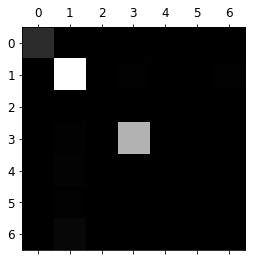

In [80]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [81]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


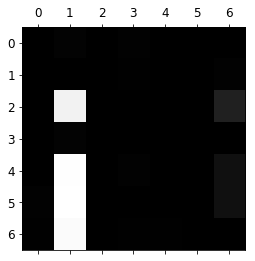

In [82]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()